# SNN-CLAPP

In [1]:
import matplotlib.pyplot as plt
from utils import load_NMNIST, train, test
from model import CLAPP_SNN

device = 'cpu'
epochs = 1
batch_size = 1

## Dataset
N-MNIST 


(34, 34, 2)
torch.Size([1, 6, 2, 34, 34])


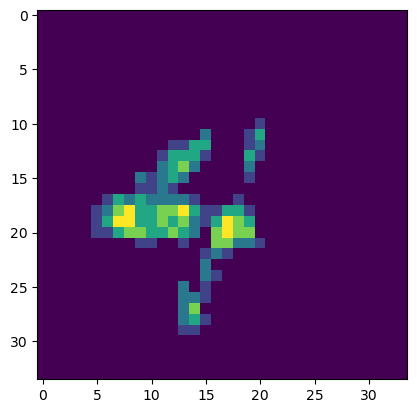

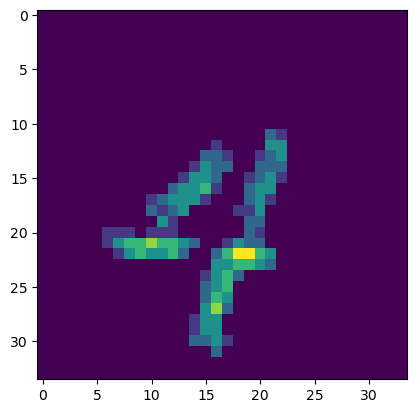

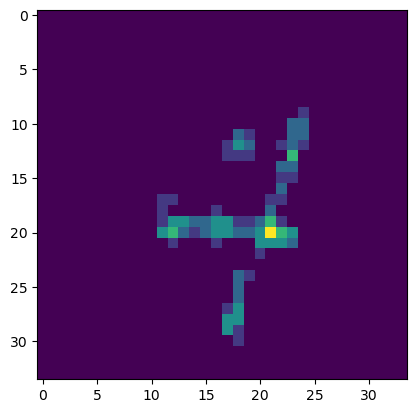

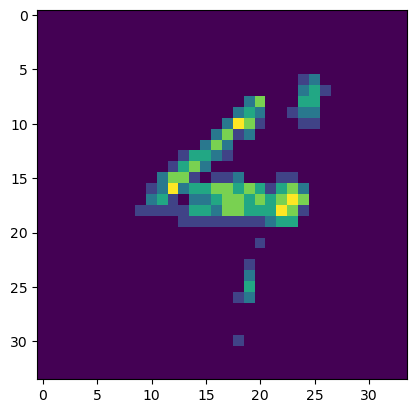

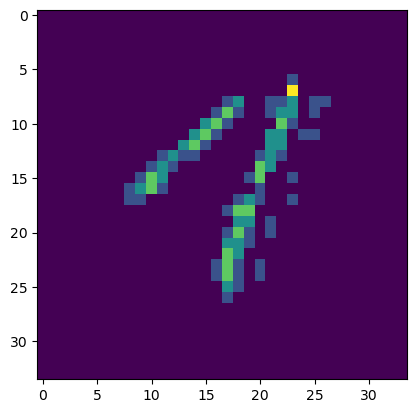

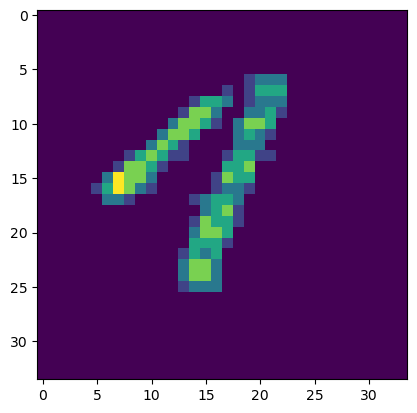

In [2]:
n_time_bins = 6
train_loader, test_loader = load_NMNIST(n_time_bins, batch_size=batch_size)

# Plot Example
frames, target = next(iter(train_loader))
print(frames.shape)
for i in range(6):
    plt.figure()
    plt.imshow(frames[0,i,0])
frames, target = next(iter(train_loader))

## Training

0it [00:00, ?it/s]/home/lars/miniconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1, 16])) that is different to the input size (torch.Size([16])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
2it [00:00,  8.79it/s]

Epoch 0, Iteration 0 
Train Loss: 0.00
Accuracy: 0.00%



502it [01:00,  8.06it/s]

Epoch 0, Iteration 500 
Train Loss: 0.14
Accuracy: 0.00%



1001it [02:05,  6.42it/s]

Epoch 0, Iteration 1000 
Train Loss: 0.03
Accuracy: 0.00%



1502it [03:15,  6.01it/s]

Epoch 0, Iteration 1500 
Train Loss: 0.00
Accuracy: 100.00%



2002it [04:18,  8.34it/s]

Epoch 0, Iteration 2000 
Train Loss: 0.00
Accuracy: 0.00%



2501it [05:28,  7.31it/s]

Epoch 0, Iteration 2500 
Train Loss: 0.06
Accuracy: 0.00%



3001it [06:33,  8.18it/s]

Epoch 0, Iteration 3000 
Train Loss: 0.06
Accuracy: 0.00%



3502it [07:39, 11.09it/s]

Epoch 0, Iteration 3500 
Train Loss: 0.00
Accuracy: 0.00%



4002it [08:42, 10.08it/s]

Epoch 0, Iteration 4000 
Train Loss: 0.00
Accuracy: 0.00%



4501it [09:47,  9.44it/s]

Epoch 0, Iteration 4500 
Train Loss: 0.06
Accuracy: 0.00%



5002it [10:51,  9.87it/s]

Epoch 0, Iteration 5000 
Train Loss: 0.06
Accuracy: 0.00%



5502it [11:53,  7.91it/s]

Epoch 0, Iteration 5500 
Train Loss: 0.00
Accuracy: 0.00%



6001it [12:51,  8.93it/s]

Epoch 0, Iteration 6000 
Train Loss: 0.00
Accuracy: 0.00%



6502it [13:48,  8.82it/s]

Epoch 0, Iteration 6500 
Train Loss: 0.00
Accuracy: 0.00%



7002it [14:44, 10.46it/s]

Epoch 0, Iteration 7000 
Train Loss: 0.00
Accuracy: 0.00%



7502it [15:42,  9.60it/s]

Epoch 0, Iteration 7500 
Train Loss: 0.00
Accuracy: 0.00%



8002it [16:39,  9.28it/s]

Epoch 0, Iteration 8000 
Train Loss: 0.00
Accuracy: 0.00%



8501it [17:38,  8.49it/s]

Epoch 0, Iteration 8500 
Train Loss: 0.06
Accuracy: 0.00%



9002it [18:32,  7.45it/s]

Epoch 0, Iteration 9000 
Train Loss: 0.40
Accuracy: 0.00%



9502it [19:29, 14.41it/s]

Epoch 0, Iteration 9500 
Train Loss: 0.00
Accuracy: 0.00%



10002it [20:28,  9.75it/s]

Epoch 0, Iteration 10000 
Train Loss: 0.00
Accuracy: 0.00%



10501it [21:25, 11.57it/s]

Epoch 0, Iteration 10500 
Train Loss: 0.00
Accuracy: 0.00%



11001it [22:20, 10.04it/s]

Epoch 0, Iteration 11000 
Train Loss: 0.00
Accuracy: 0.00%



11503it [23:18,  8.95it/s]

Epoch 0, Iteration 11500 
Train Loss: 0.06
Accuracy: 0.00%



12001it [24:12, 11.05it/s]

Epoch 0, Iteration 12000 
Train Loss: 0.00
Accuracy: 0.00%



12501it [25:10, 11.19it/s]

Epoch 0, Iteration 12500 
Train Loss: 0.00
Accuracy: 0.00%



13001it [26:07,  9.91it/s]

Epoch 0, Iteration 13000 
Train Loss: 0.00
Accuracy: 0.00%



13503it [27:04,  9.01it/s]

Epoch 0, Iteration 13500 
Train Loss: 0.40
Accuracy: 0.00%



14001it [27:56,  9.27it/s]

Epoch 0, Iteration 14000 
Train Loss: 0.00
Accuracy: 0.00%



14502it [28:56, 11.58it/s]

Epoch 0, Iteration 14500 
Train Loss: 0.09
Accuracy: 0.00%



15002it [29:54,  8.08it/s]

Epoch 0, Iteration 15000 
Train Loss: 0.19
Accuracy: 0.00%



15502it [30:52,  7.82it/s]

Epoch 0, Iteration 15500 
Train Loss: 0.00
Accuracy: 0.00%



16002it [31:49,  9.09it/s]

Epoch 0, Iteration 16000 
Train Loss: 0.00
Accuracy: 0.00%



16502it [32:47, 10.85it/s]

Epoch 0, Iteration 16500 
Train Loss: 0.00
Accuracy: 0.00%



17001it [33:44,  9.89it/s]

Epoch 0, Iteration 17000 
Train Loss: 0.00
Accuracy: 0.00%



17503it [34:41, 11.80it/s]

Epoch 0, Iteration 17500 
Train Loss: 0.06
Accuracy: 0.00%



18003it [35:37,  9.91it/s]

Epoch 0, Iteration 18000 
Train Loss: 0.06
Accuracy: 0.00%



18503it [36:32, 11.72it/s]

Epoch 0, Iteration 18500 
Train Loss: 0.00
Accuracy: 0.00%



19002it [37:28, 11.28it/s]

Epoch 0, Iteration 19000 
Train Loss: 0.00
Accuracy: 100.00%



19503it [38:25,  9.69it/s]

Epoch 0, Iteration 19500 
Train Loss: 0.00
Accuracy: 0.00%



20001it [39:21, 10.66it/s]

Epoch 0, Iteration 20000 
Train Loss: 0.00
Accuracy: 0.00%



20501it [40:16,  7.21it/s]

Epoch 0, Iteration 20500 
Train Loss: 0.41
Accuracy: 0.00%



21002it [41:17,  7.39it/s]

Epoch 0, Iteration 21000 
Train Loss: 0.09
Accuracy: 0.00%



21502it [42:12, 10.79it/s]

Epoch 0, Iteration 21500 
Train Loss: 0.00
Accuracy: 0.00%



22001it [43:07,  9.02it/s]

Epoch 0, Iteration 22000 
Train Loss: 0.08
Accuracy: 25.00%



22500it [44:03,  6.97it/s]

Epoch 0, Iteration 22500 
Train Loss: 0.00
Accuracy: 0.00%



23001it [45:00,  8.12it/s]

Epoch 0, Iteration 23000 
Train Loss: 0.27
Accuracy: 0.00%



23501it [45:57, 10.33it/s]

Epoch 0, Iteration 23500 
Train Loss: 0.00
Accuracy: 0.00%



24001it [46:54,  9.21it/s]

Epoch 0, Iteration 24000 
Train Loss: 0.00
Accuracy: 0.00%



24502it [47:52,  8.81it/s]

Epoch 0, Iteration 24500 
Train Loss: 0.27
Accuracy: 0.00%



25001it [48:52,  7.49it/s]

Epoch 0, Iteration 25000 
Train Loss: 0.06
Accuracy: 0.00%



25502it [49:49,  6.94it/s]

Epoch 0, Iteration 25500 
Train Loss: 0.39
Accuracy: 0.00%



26002it [50:48,  7.91it/s]

Epoch 0, Iteration 26000 
Train Loss: 0.00
Accuracy: 0.00%



26501it [51:45,  7.28it/s]

Epoch 0, Iteration 26500 
Train Loss: 0.04
Accuracy: 33.33%



27002it [52:39, 10.50it/s]

Epoch 0, Iteration 27000 
Train Loss: 0.00
Accuracy: 0.00%



27503it [53:34, 12.36it/s]

Epoch 0, Iteration 27500 
Train Loss: 0.00
Accuracy: 0.00%



28003it [54:29, 10.96it/s]

Epoch 0, Iteration 28000 
Train Loss: 0.00
Accuracy: 0.00%



28502it [55:24,  8.68it/s]

Epoch 0, Iteration 28500 
Train Loss: 0.00
Accuracy: 0.00%



29003it [56:21,  9.89it/s]

Epoch 0, Iteration 29000 
Train Loss: 0.06
Accuracy: 0.00%



29501it [57:17,  8.68it/s]

Epoch 0, Iteration 29500 
Train Loss: 0.29
Accuracy: 20.00%



30002it [58:16,  7.52it/s]

Epoch 0, Iteration 30000 
Train Loss: 0.06
Accuracy: 0.00%



30502it [59:14, 10.37it/s]

Epoch 0, Iteration 30500 
Train Loss: 0.00
Accuracy: 0.00%



31002it [1:00:09,  8.52it/s]

Epoch 0, Iteration 31000 
Train Loss: 0.04
Accuracy: 33.33%



31502it [1:01:06, 10.90it/s]

Epoch 0, Iteration 31500 
Train Loss: 0.00
Accuracy: 0.00%



32002it [1:02:02,  8.06it/s]

Epoch 0, Iteration 32000 
Train Loss: 0.00
Accuracy: 0.00%



32502it [1:02:57,  8.30it/s]

Epoch 0, Iteration 32500 
Train Loss: 0.00
Accuracy: 0.00%



33002it [1:03:56,  8.52it/s]

Epoch 0, Iteration 33000 
Train Loss: 0.03
Accuracy: 0.00%



33503it [1:04:52, 12.58it/s]

Epoch 0, Iteration 33500 
Train Loss: 0.00
Accuracy: 100.00%



34002it [1:05:50, 10.61it/s]

Epoch 0, Iteration 34000 
Train Loss: 0.00
Accuracy: 0.00%



34503it [1:06:44, 11.06it/s]

Epoch 0, Iteration 34500 
Train Loss: 0.00
Accuracy: 0.00%



35002it [1:07:39,  9.11it/s]

Epoch 0, Iteration 35000 
Train Loss: 0.30
Accuracy: 0.00%



35501it [1:08:35,  9.95it/s]

Epoch 0, Iteration 35500 
Train Loss: 0.00
Accuracy: 0.00%



36003it [1:09:34, 10.58it/s]

Epoch 0, Iteration 36000 
Train Loss: 0.00
Accuracy: 0.00%



36501it [1:10:27,  8.42it/s]

Epoch 0, Iteration 36500 
Train Loss: 0.00
Accuracy: 0.00%



37002it [1:11:23,  9.31it/s]

Epoch 0, Iteration 37000 
Train Loss: 0.03
Accuracy: 100.00%



37502it [1:12:21,  7.13it/s]

Epoch 0, Iteration 37500 
Train Loss: 0.03
Accuracy: 0.00%



38003it [1:13:14, 12.78it/s]

Epoch 0, Iteration 38000 
Train Loss: 0.10
Accuracy: 0.00%



38503it [1:14:11,  8.57it/s]

Epoch 0, Iteration 38500 
Train Loss: 0.03
Accuracy: 0.00%



39002it [1:15:08,  7.84it/s]

Epoch 0, Iteration 39000 
Train Loss: 0.00
Accuracy: 100.00%



39501it [1:16:07,  8.61it/s]

Epoch 0, Iteration 39500 
Train Loss: 0.17
Accuracy: 50.00%



40002it [1:17:05,  9.67it/s]

Epoch 0, Iteration 40000 
Train Loss: 0.00
Accuracy: 0.00%



40503it [1:17:59,  8.54it/s]

Epoch 0, Iteration 40500 
Train Loss: 0.17
Accuracy: 0.00%



41002it [1:18:55, 10.16it/s]

Epoch 0, Iteration 41000 
Train Loss: 0.28
Accuracy: 20.00%



41502it [1:19:50, 11.66it/s]

Epoch 0, Iteration 41500 
Train Loss: 0.00
Accuracy: 0.00%



42001it [1:20:45,  9.43it/s]

Epoch 0, Iteration 42000 
Train Loss: 0.00
Accuracy: 0.00%



42500it [1:21:39,  9.80it/s]

Epoch 0, Iteration 42500 
Train Loss: 0.00
Accuracy: 0.00%



43002it [1:22:36, 10.72it/s]

Epoch 0, Iteration 43000 
Train Loss: 0.00
Accuracy: 0.00%



43502it [1:23:32,  7.61it/s]

Epoch 0, Iteration 43500 
Train Loss: 0.10
Accuracy: 0.00%



44004it [1:24:28, 11.65it/s]

Epoch 0, Iteration 44000 
Train Loss: 0.03
Accuracy: 0.00%



44502it [1:25:23,  7.85it/s]

Epoch 0, Iteration 44500 
Train Loss: 0.19
Accuracy: 0.00%



45002it [1:26:22,  7.88it/s]

Epoch 0, Iteration 45000 
Train Loss: 0.17
Accuracy: 16.67%



45503it [1:27:17, 11.83it/s]

Epoch 0, Iteration 45500 
Train Loss: 0.00
Accuracy: 0.00%



46003it [1:28:16,  9.88it/s]

Epoch 0, Iteration 46000 
Train Loss: 0.11
Accuracy: 25.00%



46502it [1:29:11,  8.99it/s]

Epoch 0, Iteration 46500 
Train Loss: 0.00
Accuracy: 100.00%



47002it [1:30:08,  8.60it/s]

Epoch 0, Iteration 47000 
Train Loss: 0.03
Accuracy: 0.00%



47502it [1:31:07,  8.63it/s]

Epoch 0, Iteration 47500 
Train Loss: 0.00
Accuracy: 0.00%



48002it [1:32:04,  8.21it/s]

Epoch 0, Iteration 48000 
Train Loss: 0.25
Accuracy: 0.00%



48502it [1:33:00,  9.91it/s]

Epoch 0, Iteration 48500 
Train Loss: 0.00
Accuracy: 0.00%



49002it [1:33:59,  9.90it/s]

Epoch 0, Iteration 49000 
Train Loss: 0.00
Accuracy: 0.00%



49502it [1:34:54, 11.53it/s]

Epoch 0, Iteration 49500 
Train Loss: 0.00
Accuracy: 0.00%



50001it [1:35:50,  9.18it/s]

Epoch 0, Iteration 50000 
Train Loss: 0.06
Accuracy: 0.00%



50502it [1:36:47,  9.89it/s]

Epoch 0, Iteration 50500 
Train Loss: 0.00
Accuracy: 0.00%



51002it [1:37:48,  8.02it/s]

Epoch 0, Iteration 51000 
Train Loss: 0.00
Accuracy: 0.00%



51501it [1:38:43, 10.90it/s]

Epoch 0, Iteration 51500 
Train Loss: 0.00
Accuracy: 0.00%



52001it [1:39:39,  7.91it/s]

Epoch 0, Iteration 52000 
Train Loss: 0.30
Accuracy: 0.00%



52501it [1:40:34, 10.38it/s]

Epoch 0, Iteration 52500 
Train Loss: 0.00
Accuracy: 0.00%



53002it [1:41:33, 10.76it/s]

Epoch 0, Iteration 53000 
Train Loss: 0.00
Accuracy: 0.00%



53501it [1:42:28,  7.36it/s]

Epoch 0, Iteration 53500 
Train Loss: 0.12
Accuracy: 0.00%



54000it [1:43:24, 11.91it/s]

Epoch 0, Iteration 54000 
Train Loss: 0.03
Accuracy: 0.00%



54501it [1:44:22, 11.97it/s]

Epoch 0, Iteration 54500 
Train Loss: 0.03
Accuracy: 0.00%



55001it [1:45:20,  8.69it/s]

Epoch 0, Iteration 55000 
Train Loss: 0.03
Accuracy: 0.00%



55502it [1:46:15, 10.46it/s]

Epoch 0, Iteration 55500 
Train Loss: 0.00
Accuracy: 0.00%



56002it [1:47:13,  6.05it/s]

Epoch 0, Iteration 56000 
Train Loss: 0.30
Accuracy: 0.00%



56502it [1:48:13,  8.48it/s]

Epoch 0, Iteration 56500 
Train Loss: 0.24
Accuracy: 0.00%



57001it [1:49:09, 13.50it/s]

Epoch 0, Iteration 57000 
Train Loss: 0.00
Accuracy: 0.00%



57503it [1:50:07,  9.44it/s]

Epoch 0, Iteration 57500 
Train Loss: 0.03
Accuracy: 0.00%



58002it [1:51:05,  8.79it/s]

Epoch 0, Iteration 58000 
Train Loss: 0.00
Accuracy: 100.00%



58501it [1:52:02, 10.30it/s]

Epoch 0, Iteration 58500 
Train Loss: 0.03
Accuracy: 0.00%



59002it [1:52:57, 10.05it/s]

Epoch 0, Iteration 59000 
Train Loss: 0.00
Accuracy: 100.00%



59502it [1:53:54,  7.37it/s]

Epoch 0, Iteration 59500 
Train Loss: 0.36
Accuracy: 0.00%



60000it [1:54:50,  8.71it/s]


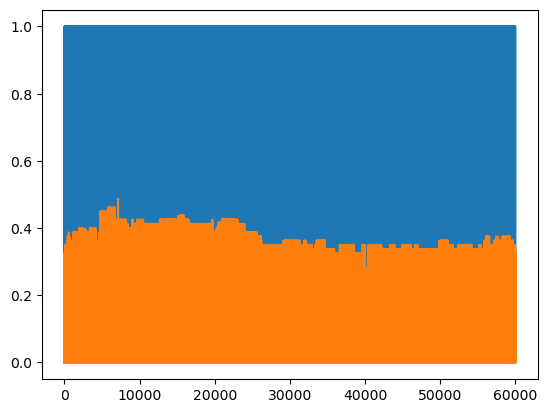

0it [00:00, ?it/s]


TypeError: forward() missing 1 required positional argument: 'bf'

In [3]:

SNN = CLAPP_SNN(2312, [512, 512, 512], 16, n_time_bins).to(device)
acc_hist, loss_hist = train(SNN, train_loader, epochs, device)
plt.plot(acc_hist)
plt.plot(loss_hist)
plt.show()
correct = test(SNN, test_loader, device)
print(correct)
print('Accuracy:', sum(correct)/10000)

# Analyze Weights

tensor(0.0084, grad_fn=<MeanBackward0>) tensor(-0.0027, grad_fn=<MeanBackward0>)


/tmp/ipykernel_339545/2971768224.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


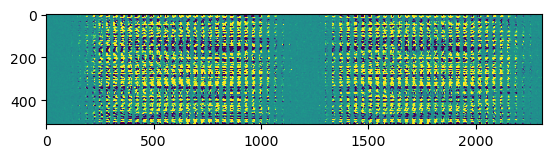

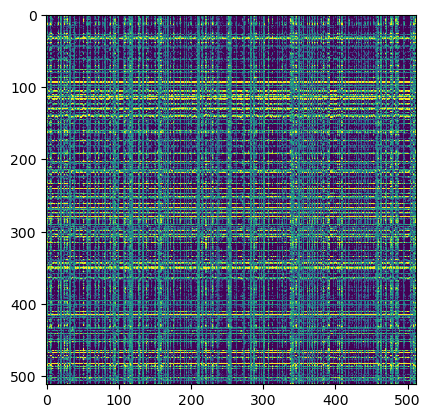

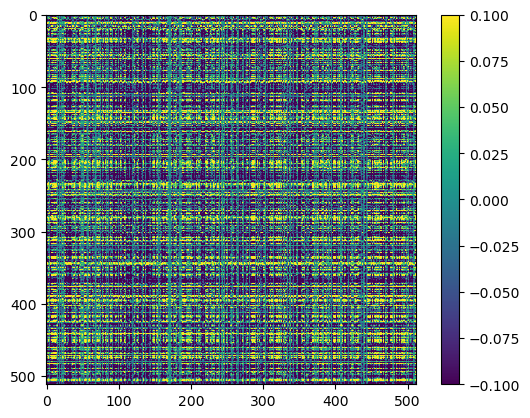

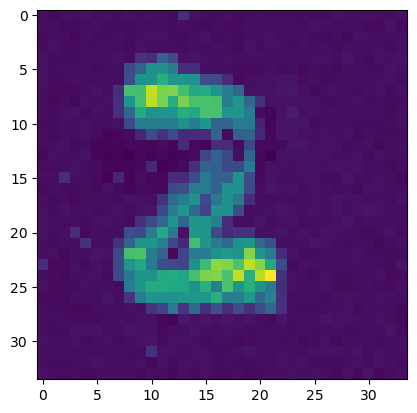

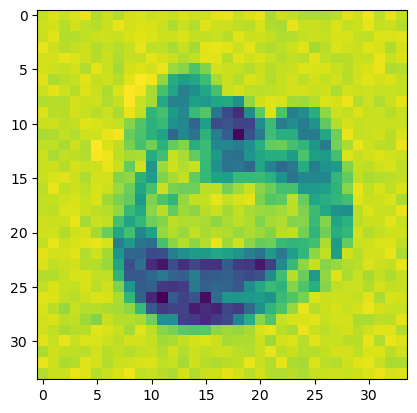

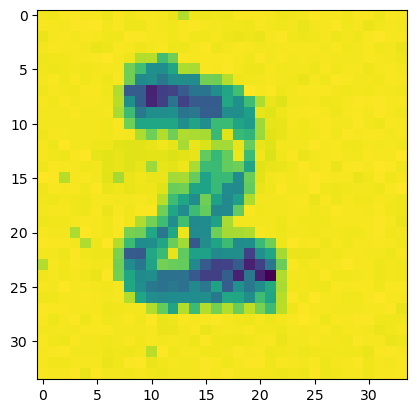

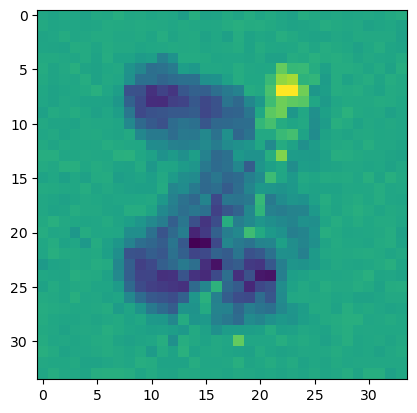

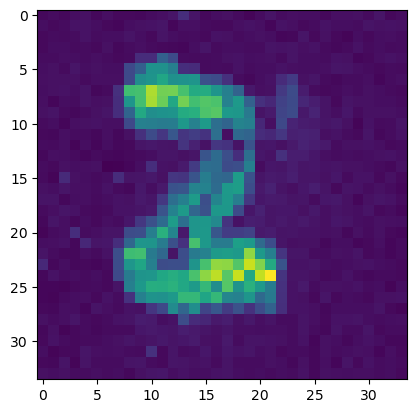

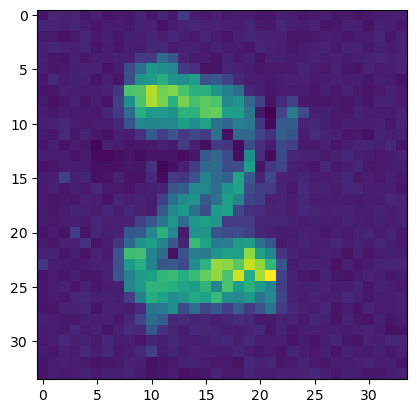

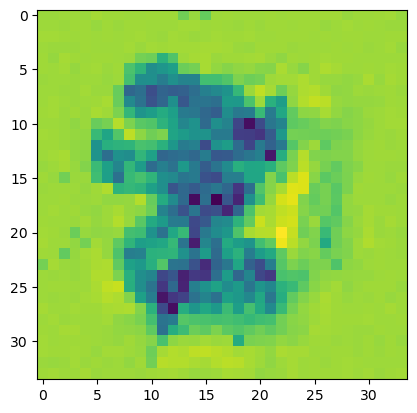

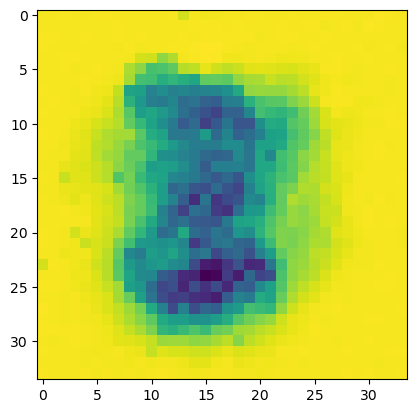

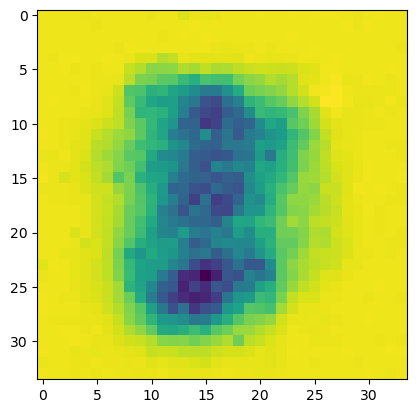

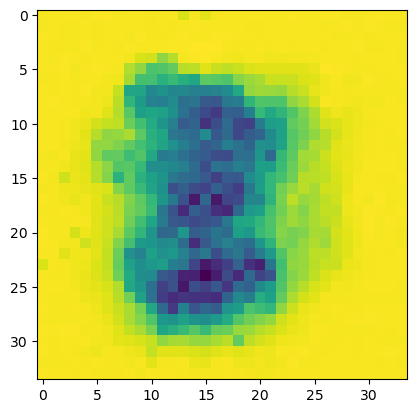

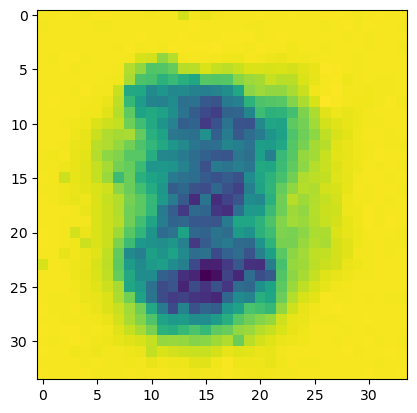

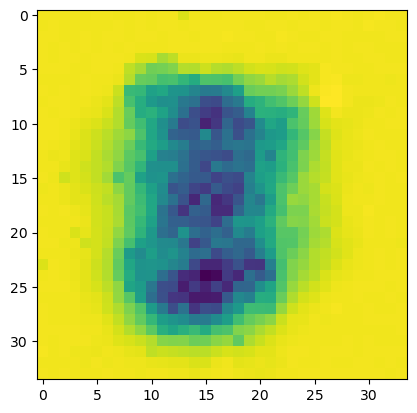

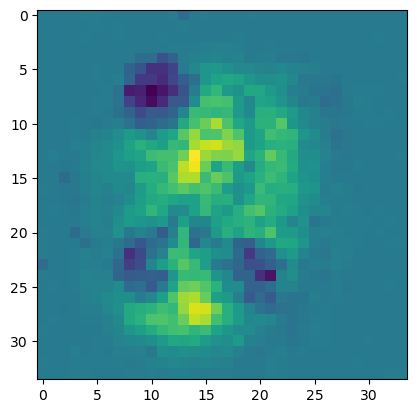

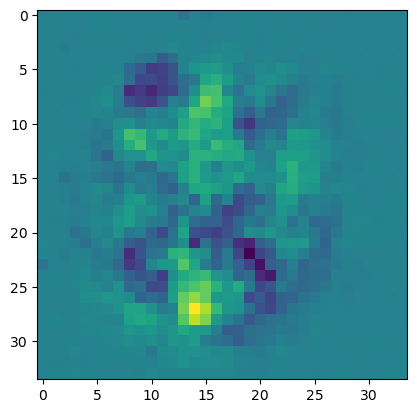

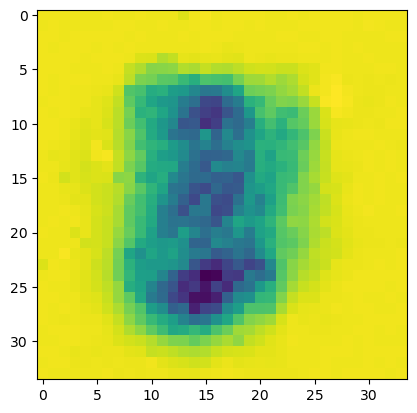

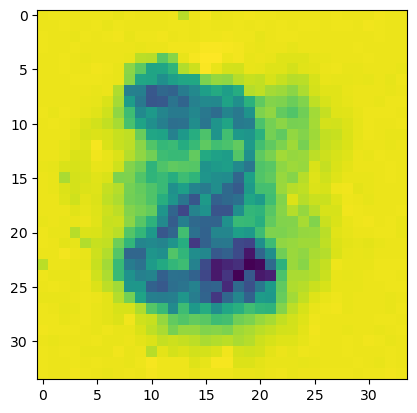

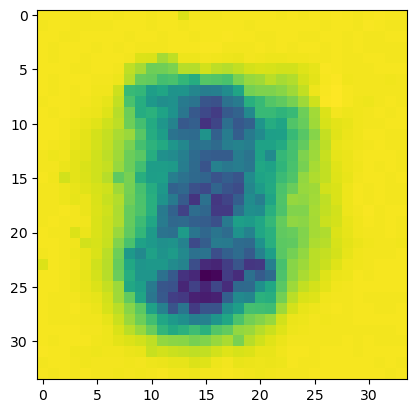

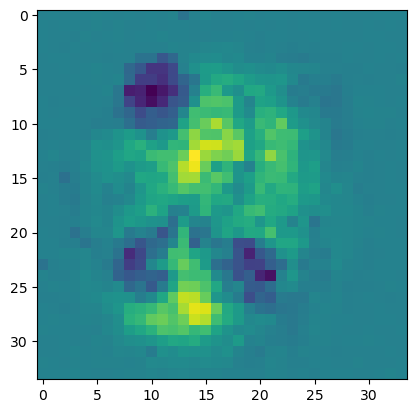

In [38]:
layer1 = SNN.clapp[0].fc.weight
print(layer1.mean(), SNN.clapp[0].pred.weight.mean())
layer2 = SNN.clapp[1].fc.weight @ layer1
layer3 = SNN.clapp[2].fc.weight @ layer2
plt.figure()
plt.imshow(SNN.clapp[0].fc.weight.detach(), vmax=1e-1, vmin=-1e-1)
plt.figure()
plt.imshow(SNN.clapp[1].fc.weight.detach(), vmax=1e-1, vmin=-1e-1)
plt.figure()
plt.imshow(SNN.clapp[2].fc.weight.detach(), vmax=1e-1, vmin=-1e-1)
plt.colorbar()
for i in range(18,24):
    plt.figure()
    plt.imshow(layer1[i].view(2, 34, 34).detach().sum(axis=0))
for i in range(18,24):
    plt.figure()
    plt.imshow(layer2[i].view(2, 34, 34).detach().sum(axis=0))
for i in range(18,24):
    plt.figure()
    plt.imshow(layer3[i].view(2, 34, 34).detach().sum(axis=0))

# Train output Projection